In [1]:
import numpy as np
import os
import json
from matplotlib import pyplot as plt, cm
import tensorflow as tf
import numpy as np
import cv2 as cv

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam

# clone the repository, if it doesnt exist already
try:
    from transforms.apply_patch import ApplyPatch
except:
    # clone the repository
    !git clone https://github.com/pralab/ImageNet-Patch


fatal: destination path 'ImageNet-Patch' already exists and is not an empty directory.


In [2]:
Model = ResNet50

model = Model(weights='imagenet', include_top=True)

#model.summary()

In [3]:
# Download the json file of list of classes in imagenet with index

if os.path.isfile('imagenet_class_index.json') == False:
    !wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel  = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])

print("Number of classes of class={}".format(len(classlabel)))

Number of classes of class=1000


# ----------------------------------------------------------------------------------------------------------------------

# Imagenet-Patch

# ----------------------------------------------------------------------------------------------------------------------

In [145]:
os.chdir(root_dir)
os.chdir('ImageNet-Patch')
os.getcwd()

'C:\\Users\\rohan\\OneDrive\\Documents\\Github\\minor_project\\ImageNet-Patch'

In [146]:
import gzip
import pickle

import torch
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torchvision.models as models

from utils.utils import set_all_seed
from utils.utils import target_transforms


from transforms.apply_patch import ApplyPatch

from utils.visualization import show_batch_with_patch, plot_patch_predictions, show_imagenet_patch, show_batch_with_patch

set_all_seed(42)

# dictionary with the ImageNet label names
with open(os.path.join(os.getcwd(), "assets/imagenet1000_clsidx_to_labels.txt")) as f:
    target_to_classname = eval(f.read())

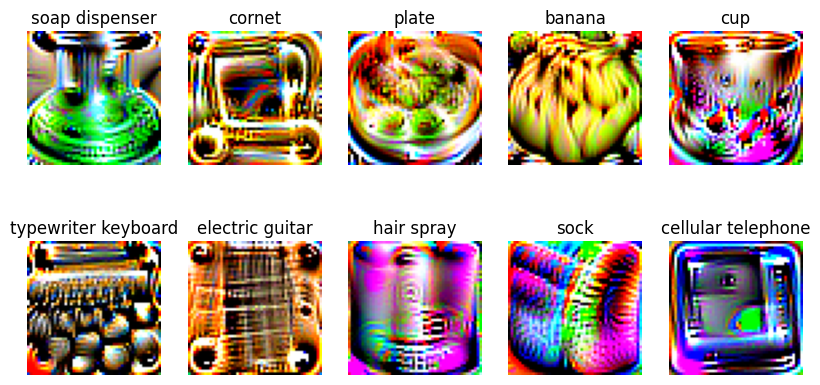

In [147]:
# Load the patches


with gzip.open(os.path.join(os.getcwd(), "assets/imagenet_patch.gz"), 'rb') as f:
    imagenet_patch = pickle.load(f)

patches, targets, info = imagenet_patch

show_imagenet_patch(patches, targets)

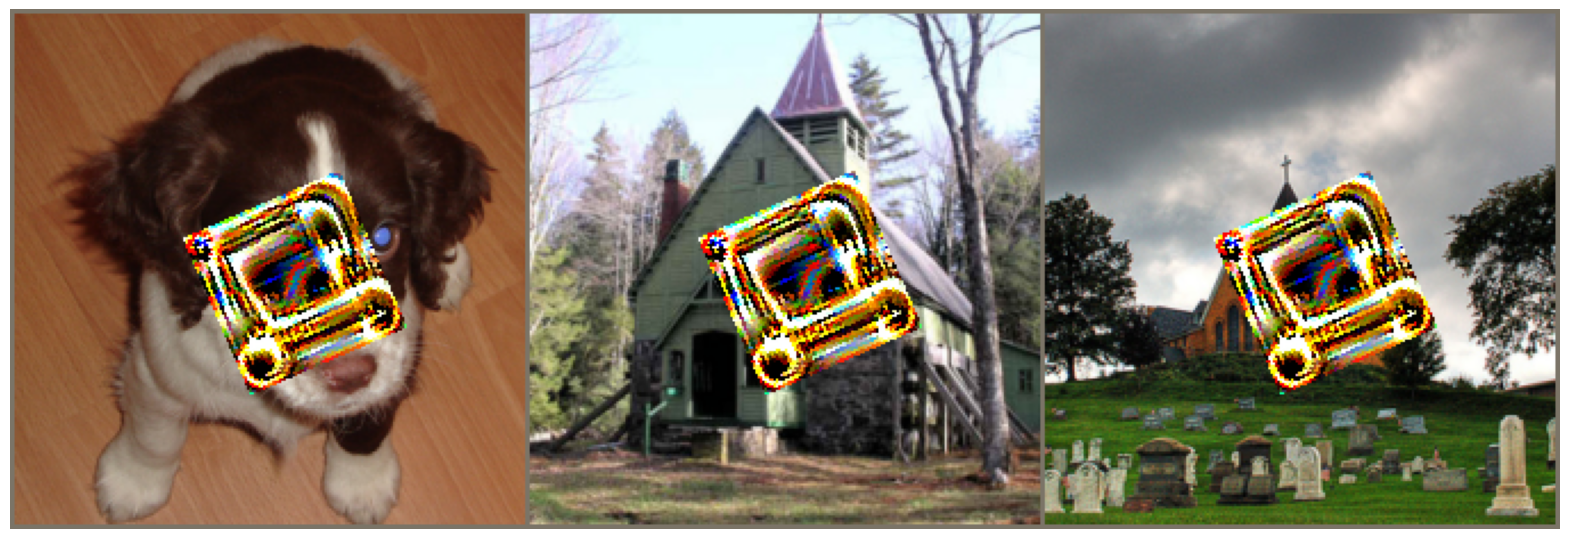

In [168]:
# Choose an integer in the range 0-9 to select the patch
patch_id = 1
patch = patches[patch_id]      # get the chosen patch
target = targets[patch_id]

# Instantiate the ApplyPatch module setting the patch and the affine transformation that will be applied
apply_patch = ApplyPatch(patch, patch_size=info['patch_size'],
                         translation_range=(.1, .1),
                         rotation_range=30,
                         scale_range=(1.5, 1.5)           # scale range wrt image dimensions
                         )

# For convenience the preprocessing steps are splitted to compute also the clean predictions
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
patch_normalizer = Compose([apply_patch, normalizer])

# Load the data
preprocess = Compose([Resize(256), CenterCrop(224), ToTensor()])    # ensure images are 224x224
dataset = ImageFolder(os.path.join(os.getcwd(), "assets/data"),
                      transform=preprocess,
                      target_transform=target_transforms)
data_loader = DataLoader(dataset, batch_size=3, shuffle=True)
x, y = next(iter(data_loader))  # load a mini-batch
x_clean = normalizer(x)
x_adv = patch_normalizer(x)

show_batch_with_patch(x_adv, transforms=patch_normalizer, figsize=(20, 10))

In [154]:
# Load model
Model = ResNet50

model = Model(weights='imagenet', include_top=True)


# Convert PyTorch tensor object to NumPy array
x_clean = x_clean.numpy()
x_adv = x_adv.numpy()
x_clean.shape


# Convert NumPy array to TensorFlow tensor object
x_clean = tf.convert_to_tensor(x_clean)
x_adv = tf.convert_to_tensor(x_adv)

# Convert the torch shape was [?, 3, 224, 244], convert it into [?, 224, 224, 3] for resnet50 model
x_clean = np.transpose(x_clean, (0, 2, 3, 1))
x_adv = np.transpose(x_adv, (0, 2, 3, 1))

# Feed the model with the clean images
output_clean = model(x_clean)
clean_predictions = tf.math.argmax(output_clean, axis=1)
clean_predictions = clean_predictions.numpy()

# Feed the model with the images corrupted by the patch
output_adv = model(x_adv)
adv_predictions = tf.math.argmax(output_adv, axis=1)
adv_predictions = adv_predictions.numpy()

# # Convert the torch shape was [?, 224, 244, 3], convert it into [?, 3, 224, 224] for resnet50 model
# x_clean = np.transpose(x_clean, (0, 3, 1, 2))
# x_adv = np.transpose(x_adv, (0, 3, 1, 2))

# x_clean = torch.from_numpy(x_clean)
# x_adv = torch.from_numpy(x_adv)

# plot_patch_predictions(x_clean, x_adv, clean_predictions, adv_predictions,
#                        true_label=y.cpu().detach().numpy(), target=int(target.item()),
#                        figsize=(30, 6), normalizer=normalizer)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


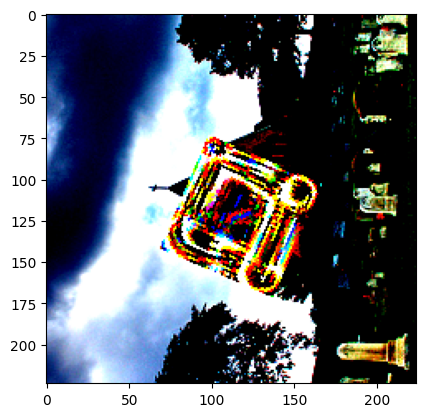

In [183]:
r, g, b = np.split(x_adv[0], 3)

plt.imshow(x_adv[2].T)

## The adversarial images that we got has been trained on pytorch's axelnet, and doesn't work well as targetted attack on other model such as pytorch's resnet50, tensorflow's resnet50

# ----------------------------------------------------------------------------------------------------------------------


# Testing on individual images from internet


# ----------------------------------------------------------------------------------------------------------------------

In [18]:
# Load model
Model = ResNet50
model = Model(weights='imagenet')

In [19]:
os.chdir(root_dir)
os.getcwd()

'C:\\Users\\rohan\\OneDrive\\Documents\\Github\\minor_project'

In [20]:
os.chdir('resnet50')
os.getcwd()

'C:\\Users\\rohan\\OneDrive\\Documents\\Github\\minor_project\\resnet50'

1/1 [==============================] - 0s 137ms/step


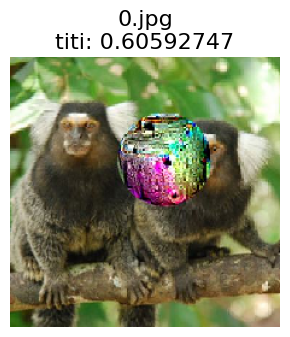

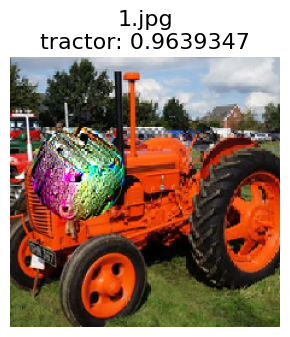

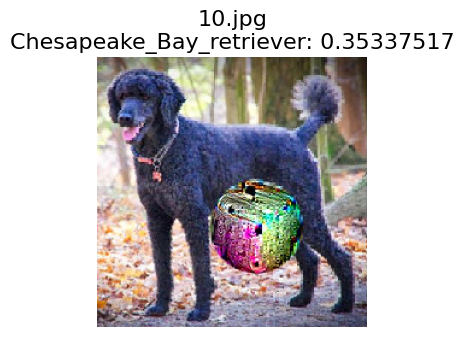

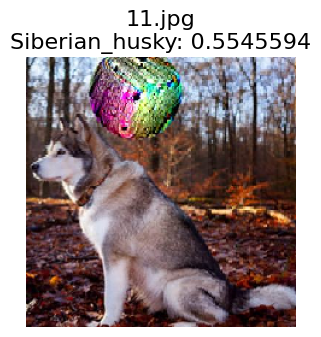

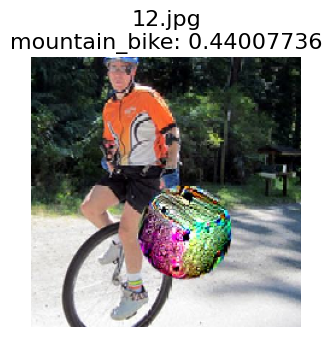

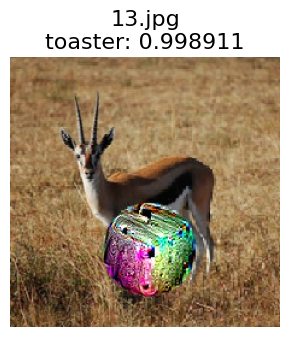

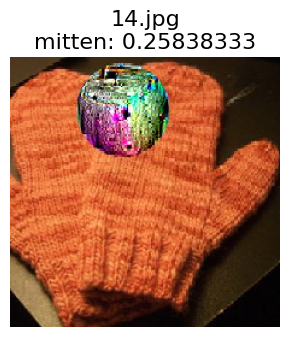

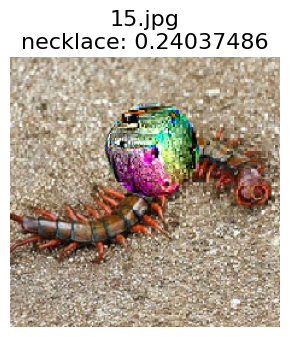

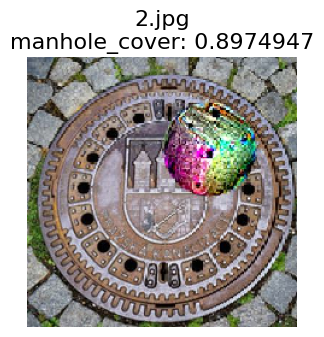

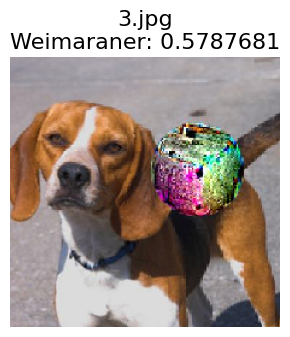

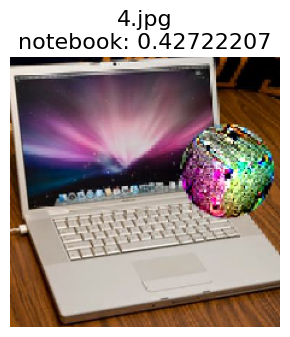

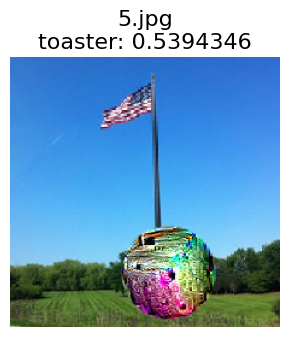

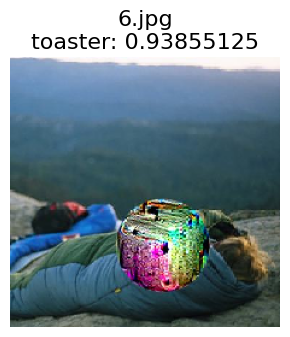

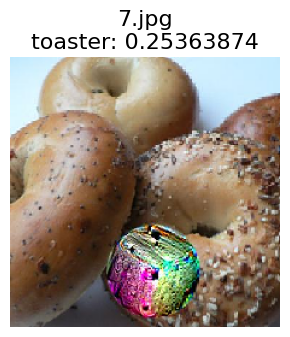

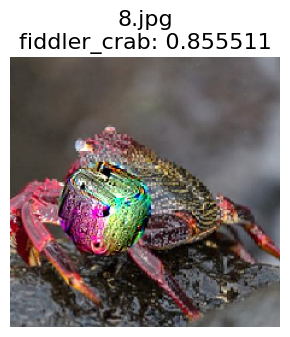

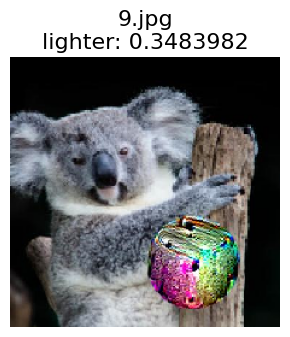

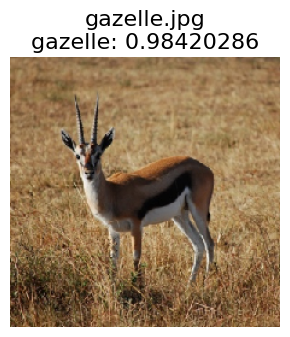

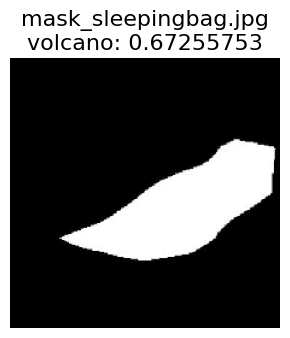

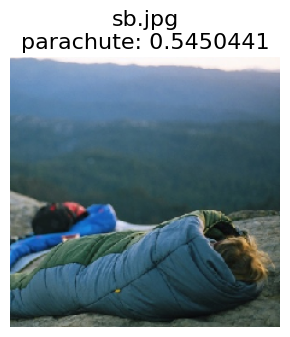

In [119]:
# Load image dataset and convert them to a Numpy array

images = []

for i, file in enumerate(os.listdir()):
    if file.endswith('.jpg'):
        img = load_img(file, target_size=(224, 224))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)

        # Preparing input data for VGG16
        images.append(img.copy())

    #     tmp_img = preprocess_input(img.copy())
        img_pred = model.predict(img)
        prediction = decode_predictions(img_pred, top=1)
        # prediction

        # class_lbl = classlabel.index(prediction[0][0][1])
        # print(prediction, class_lbl)

        # Rendering
        plt.figure(figsize=(3, 4))
        plt.title(file + '\n' + str(prediction[0][0][1]) + ': ' + str(prediction[0][0][2]), fontsize=16)
        plt.imshow(np.uint8(img[0]))
        plt.axis('off')
        plt.tight_layout()

In [184]:
images.shape

AttributeError: 'list' object has no attribute 'shape'

## Display input image with prediction

1/1 [==============================] - 0s 165ms/step
[[('n04442312', 'toaster', 0.99943084)]] 859


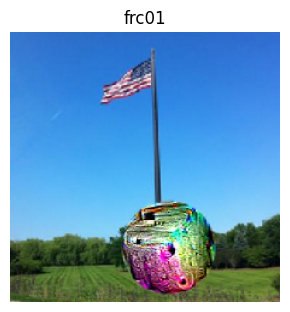

In [131]:
# img = load_img('6.jpg', target_size=(224, 224))
# img = img_to_array(img).astype(np.uint8)
# img = np.expand_dims(img, axis=0)

# tmp_img = preprocess_input(img.copy())
# img_pred = model.predict(tmp_img)
# prediction = decode_predictions(img_pred, top=1)

# class_lbl = classlabel.index(prediction[0][0][1])
# print(prediction, class_lbl)

# # Rendering
# plt.figure(figsize=(3, 4))
# plt.title('frc01')
# plt.imshow(np.uint8(img[0]))
# plt.axis('off')
# plt.tight_layout()

img = cv.imread('5.jpg')
img = cv.resize(img, (224, 224))
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)

tmp_img = preprocess_input(img.copy())
img_pred = model.predict(tmp_img)
prediction = decode_predictions(img_pred, top=1)

class_lbl = classlabel.index(prediction[0][0][1])
print(prediction, class_lbl)

# Rendering
plt.figure(figsize=(3, 4))
plt.title('frc01')
plt.imshow(np.uint8(img[0]))
plt.axis('off')
plt.tight_layout()

1/1 [==============================] - 0s 191ms/step


([[('n04442312', 'toaster', 0.99943084)]], 859)

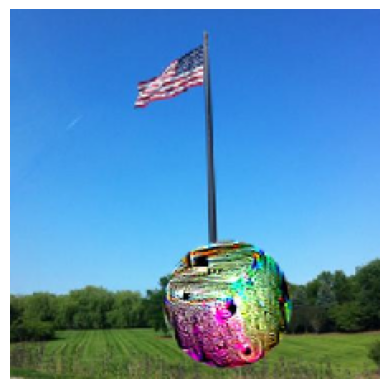

In [132]:
plt.axis('off')
selected_img = img.copy()
plt.imshow(np.uint8(selected_img[0]))

tmp_img = selected_img.copy()
tmp_img = preprocess_input(tmp_img)

img_pred = model.predict(tmp_img)
prediction = decode_predictions(img_pred, top=1)
class_lbl = classlabel.index(prediction[0][0][1])
prediction, class_lbl

# Preparing Gradcam function

In [134]:
''' When the softmax activation function is applied to the last layer of model,
    it may obstruct generating the attention images,
    so you should replace the function to a linear activation function.
'''

replace2linear = ReplaceToLinear()

# # Instead of using the ReplaceToLinear instance above,
# # you can also define the function from scratch as follows:
# def model_modifier_function(cloned_model):
#     cloned_model.layers[-1].activation = tf.keras.activations.linear




''' And then, you MUST create Score instance or define score function that returns target scores.
    Here, they return the score values corresponding Goldfish, Bear, Assault Rifle.
'''

score = CategoricalScore(class_lbl)

# # Instead of using CategoricalScore object,
# # you can also define the function from scratch as follows:
# def score_function(output):
#     # The `output` variable refers to the output of the model,
#     # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
#     return (output[0][1], output[1][294], output[2][413])

# GradCAM

#### Saliency is one of useful way of visualizing attention that appears the regions of the input image that contributes the most to the output value. GradCAM is another way of visualizing attention over input. Instead of using gradients of model outputs, it uses of penultimate layer output (that is the convolutional layer just before Dense layers).

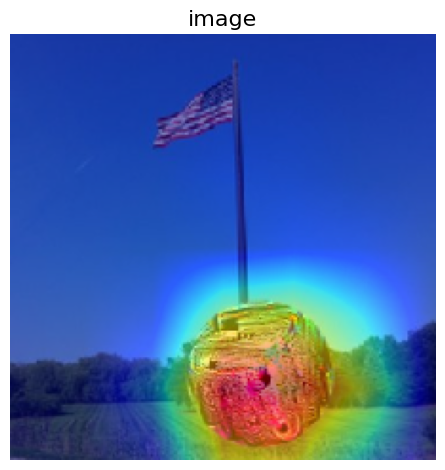

In [135]:
image_titles = ['image']

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              selected_img.copy().astype(np.float32),
              penultimate_layer=-1)


for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    plt.title(title, fontsize=16)
    plt.imshow(np.uint8(selected_img[0]))
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    plt.axis('off')
    plt.tight_layout()

In [136]:
tmp_heatmap = cam[i].copy()

# img_tmp = selected_img / 255

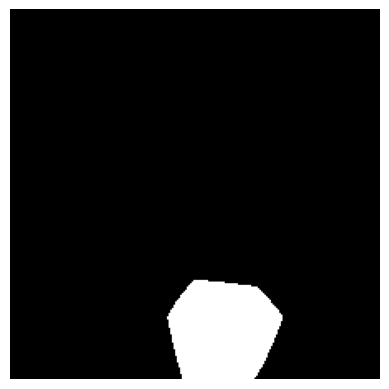

In [188]:
fig = plt.figure()

binary_patch_mask = cam[i].copy()


# can set patch mask as 1 - (patch_size<eg: 3.5, in our case>)
binary_patch_mask[np.where(binary_patch_mask > 1 - 0.35)] = 1.
binary_patch_mask[np.where(binary_patch_mask <= 1 - 0.35)] = 0.

# binary_image_mask = np.where(binary_patch_mask==1., 0., 1.)

# # Convert the 1 channel mask to 3 channel mask for each channel(R, G, B)
# patch_mask = cv.merge((binary_patch_mask, binary_patch_mask, binary_patch_mask))
# image_mask = cv.merge((binary_image_mask, binary_image_mask, binary_image_mask))


# rgb_patch = (selected_img[0] * patch_mask)
# rgb_image = (selected_img[0] * image_mask)

plt.axis('off')
plt.imshow(binary_patch_mask, cmap='gray')

# plt.savefig('mask_sleepingbag.jpg', transparent=True, bbox_inches='tight', pad_inches=0)
# plt.axis('off')
# plt.imshow(patch_mask + rgb_image)

# # Display the clean image and patch image
# fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# axes[0].imshow(rgb_patch)
# axes[0].axis('off')

# axes[1].imshow(rgb_image)
# axes[1].axis('off')

# Use impainting technique

In [138]:
from modified_inpaint import inpaint

src_img = (selected_img[0]).copy()
img = (selected_img[0]).copy()
mask = patch_mask[:, :, 0].astype(bool)

In [139]:
imggg = inpaint(src_img, img, mask)

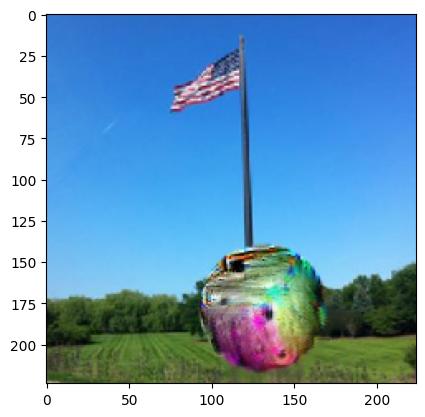

In [140]:
plt.imshow(imggg)

In [141]:
new_x = np.expand_dims(src_img.copy(), axis=0)

# Preparing input data for VGG16
inp_x = preprocess_input(new_x.copy())

blur_img_pred = model.predict(inp_x.copy())
blur_pred = decode_predictions(blur_img_pred, top=1)
blur_pred

blur_class_lbl = classlabel.index(blur_pred[0][0][1])
blur_pred, blur_class_lbl

1/1 [==============================] - 0s 132ms/step


([[('n03355925', 'flagpole', 0.8710104)]], 557)

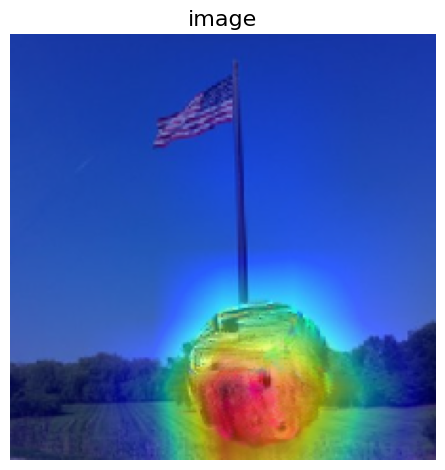

In [142]:
# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              new_x.copy().astype(np.float32),
              penultimate_layer=-1)

for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    plt.title(title, fontsize=16)
    plt.imshow(np.uint8(new_x[0]))
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    plt.axis('off')
    plt.tight_layout()

In [ ]:
# fig.savefig('.jpg', transparent=True, bbox_inches='tight', pad_inches=0)